Code writer: [Christian Benitez](https://github.com/christianmbr).

In [ ]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import hstack

import matplotlib.pyplot as plt

import re

In [ ]:
nltk.download()

# Loading data base

Database taken from [Kaggle.com](https://www.kaggle.com/datasets/joyshil0599/hotel-dataset-rates-reviews-and-amenities5k?select=booking_hotel.csv)

In [ ]:
data_base_path = '/content/drive/Othercomputers/Mi portátil/Universidad Semestres/Semestre 10/machine_learning/booking_hotel.csv'
db = pd.read_csv(data_base_path, encoding='windows-1252')

# Database analysis

In [ ]:
print(db.columns, '\n')
print('Shape of data base: ', db.shape)

Index(['Hotel Name', 'Location', 'Rating', 'Review Score', 'Number of   ',
       'Room    Score', 'Room Type', 'Bed Type',
       'Room Price (in BDT or any other currency)'],
      dtype='object') 

Shape of data base:  (3465, 9)


In [ ]:
# Renaming columns.
new_name_columns = {
  'Number of   ': 'Number of',
  'Room    Score': 'Room Score', 
  'Room Price (in BDT or any other currency)': 'Room Price'
}

db = db.rename(columns=new_name_columns)
print(db.columns)

Index(['Hotel Name', 'Location', 'Rating', 'Review Score', 'Number of',
       'Room Score', 'Room Type', 'Bed Type', 'Room Price'],
      dtype='object')


In this case it is not necessary to take the name, location, number of ratings to train a model.

In [ ]:
columns_to_delete = ['Hotel Name', 'Location', 'Number of']

db = db.drop(columns_to_delete, axis=1)

In [ ]:
print(db['Review Score'].unique())
print(len(db['Room Type'].unique()))
print(len(db['Bed Type'].unique()))

['Very Good' 'Good' 'Wonderful' 'Excellent' 'Review score' nan
 'Exceptional']
921
121


Cleaning Room Price column.

In [ ]:
# Cleaning Room Price column.
db['Room Price'] = db['Room Price'].str.replace(',', '')
db['Room Price'] = db['Room Price'].apply(lambda x: re.sub('[^0-9\.,]', '', x)).astype(float)
db['Room Price'].dtype

dtype('float64')

Cleaning Rating column

In [ ]:
# Removing all empty fields in the column.
print(db[db['Rating'].isna()][:5])

db = db.dropna(subset=['Rating'])

In [ ]:
len(db[db['Rating'].isna()])

0

In [ ]:
def clean_rating(rating):
    # Usamos una expresión regular para extraer los dígitos y los puntos de la cadena
    pattern = r'(\d+\.\d+)'
    match = re.search(pattern, rating)
    if match:
        # Si encontramos una coincidencia, devolvemos el número flotante
        return float(match.group(1))
    else:
        # Si no encontramos una coincidencia, devolvemos NaN (o cualquier otro valor que quieras utilizar)
        return float('nan')

# Aplicamos la función 'clean_rating' a la columna 'Rating'
db['Rating'] = db['Rating'].apply(clean_rating)

<ipython-input-11-83cb4249dce0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['Rating'] = db['Rating'].apply(clean_rating)


In [ ]:
db['Rating'].dtype

dtype('float64')

Cleaning Review Score

In [ ]:
# Deleting empty data.
db = db.dropna(subset=['Review Score'])

In [ ]:
print(db['Review Score'].unique())

['Very Good' 'Good' 'Wonderful' 'Excellent' 'Review score' 'Exceptional']


In [ ]:
index_to_delete = db[db['Review Score'] == 'Review score'].index
db = db.drop(index_to_delete, axis=0)

In [ ]:
mapping = {
  'Exceptional': 4,
  'Wonderful': 3, 
  'Excellent': 2,
  'Very Good': 1, 
  'Good': 0
}

db['Review Score'] = db['Review Score'].replace(mapping)

In [ ]:
print(db['Review Score'].unique())
print(db['Review Score'].dtype)

[1 0 3 2 4]
int64


Reviewing the database

In [ ]:
# Droping all empty data.
db = db.dropna()

In [ ]:
for column in db.columns:
  print(column, db[column].dtype)

Rating float64
Review Score int64
Room Score float64
Room Type object
Bed Type object
Room Price float64


In [ ]:
db.head()

,Rating,Review Score,Room Score,Room Type,Bed Type,Room Price
0,8.2,1,8.6,Deluxe Double or Twin Room,1 double or 2 twins,146026.0
2,8.3,1,8.9,2 Bedroom Pool Villa,2 queen beds,435384.0
3,7.7,0,8.1,Executive Double Room,1 full bed,146240.0
4,9.3,3,9.6,Villa with Garden View,1 double or 2 twins,621072.0
5,8.1,1,8.4,One Bedroom Deluxe(Flash Sales),1 full bed,178109.0


Cleaning string columns.

In [ ]:
stop_words = stopwords.words("english")

In [ ]:
def cleaner_word(text):
  tokenized = RegexpTokenizer(r'\w+').tokenize(text)
  clean = []
  for word in tokenized:
    if word not in stop_words:
      clean.append(word)
  return ' '.join(clean)

In [ ]:
# Cleaning string columns.
db['Room Type'] = db['Room Type'].apply(cleaner_word)
db['Bed Type'] = db['Bed Type'].apply(cleaner_word)

In [ ]:
print(db.shape)
db.head()

(2433, 6)


,Rating,Review Score,Room Score,Room Type,Bed Type,Room Price
0,8.2,1,8.6,Deluxe Double Twin Room,1 double 2 twins,146026.0
2,8.3,1,8.9,2 Bedroom Pool Villa,2 queen beds,435384.0
3,7.7,0,8.1,Executive Double Room,1 full bed,146240.0
4,9.3,3,9.6,Villa Garden View,1 double 2 twins,621072.0
5,8.1,1,8.4,One Bedroom Deluxe Flash Sales,1 full bed,178109.0


In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
room_type_vectorized = vectorizer.fit_transform(db['Room Type'])
bed_type_vectorized = vectorizer.fit_transform(db['Bed Type'])

In [ ]:
y = db.pop('Rating')

In [ ]:
db.head()

,Review Score,Room Score,Room Type,Bed Type,Room Price
0,1,8.6,Deluxe Double Twin Room,1 double 2 twins,146026.0
2,1,8.9,2 Bedroom Pool Villa,2 queen beds,435384.0
3,0,8.1,Executive Double Room,1 full bed,146240.0
4,3,9.6,Villa Garden View,1 double 2 twins,621072.0
5,1,8.4,One Bedroom Deluxe Flash Sales,1 full bed,178109.0


In [ ]:
print('Number of features vectoriced Room Type: ', min(room_type_vectorized.shape)-1)
print('Number of features vectoriced Bed Type: ', min(bed_type_vectorized.shape)-1)

Number of features vectoriced Room Type:  328
Number of features vectoriced Bed Type:  17


In [ ]:
room_bed_type_stack_vectorized = hstack((room_type_vectorized, bed_type_vectorized))

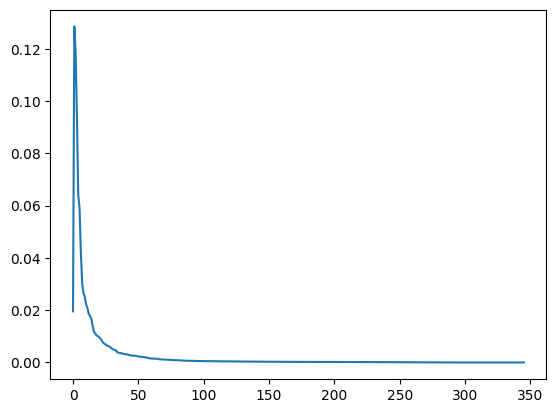

In [ ]:
tsvd = TruncatedSVD(n_components=min(room_bed_type_stack_vectorized.shape)-1)
tsvd.fit(room_bed_type_stack_vectorized)
plt.plot(tsvd.explained_variance_ratio_)

In [ ]:
tsvd = TruncatedSVD(n_components=75)
bed_room_type_SVD = tsvd.fit_transform(room_bed_type_stack_vectorized)

In [ ]:
print('Num features bed_type and room_type:', bed_room_type_SVD.shape[1])
print(bed_room_type_SVD.shape)

Num features bed_type and room_type: 75
(2433, 75)


In [ ]:
db[:1]

,Review Score,Room Score,Room Type,Bed Type,Room Price
0,1,8.6,Deluxe Double Twin Room,1 double 2 twins,146026.0


In [ ]:
features = hstack([bed_room_type_SVD, db[['Review Score', 'Room Score', 'Room Price']].values])

In [ ]:
db[['Review Score', 'Room Score', 'Room Price']].shape

(2433, 3)

In [ ]:
room_bed_type_stack_vectorized.shape

(2433, 347)

In [ ]:
features.shape

(2433, 350)